## Import design libraries

In [1]:
import sys
sys.path.append('..')

In [2]:
import gdspy
import numpy as np
from importlib import reload
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator
from QCreator import meshing

# Specify constant, everything in microns

In [3]:
tl_core = 20.
tl_gap = 12.
tl_ground = 10.

# Auxiliary functions -> move to gsc file in the future

In [4]:
def draw_single_resonator_plus_qubit(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length, qubit ,coupler_name):
    # 2. Create main copler:
    total_length=0
    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start_x, central_line_y), 
                                                                (coupler_start_x+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)
    total_length = total_length + coupler_length

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, 
                       grounding_between = [(2,3)])

    # 6. Create closed meander of resonator
    closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length,
                                                length_left =150,
                                                length_right =300,
                                                first_step_orientation ='left',
                                                meander_orientation = 0,meander_type='round')
    total_length = total_length + closed_end_meander.length
    # 7. Create grounding of resonator
    resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])
   
    # 8. Create fanout to create open end of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

    # 9. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

    # 10. Connect open end with the coupler part of the qubit
    open_end=sample.connect_cpw(fanout_for_open_end,qubit,'down',coupler_name,name='right open end',points=[])
    total_length = total_length + open_end.length
    res_params = total_length
    
    return g1, g2, res_params
######################################################################################################################
def draw_double_resonator(coupler_start, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length1,length_left1,length_right1, closed_end_meander_length2,
                          length_left2,length_right2,open_length1,open_length2,orientation='left'):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                                (coupler_start+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core, resonator_ground, resonator_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap, resonator_gap, resonator_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed end of resonator
    if orientation =='left':
        port1='port1'
        port2='port2'
        direction2='up'
        direction1='down'
        closed_end_direction2='up'
        closed_end_direction1='down'
        angle2=np.pi
        angle1=0
    else:
        port1='port2'
        port2='port1'
        closed_end_direction2='up'
        closed_end_direction1='down'
        direction2='down'
        direction1='up'
        angle1=np.pi
        angle2=0
        
    fanout_for_closed_end = sample.fanout(o=main_coupler, port=port1, name='closed end resonator fanout', grouping=[1, 4])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width,
                       grounding_between = [(0,1), (3,4)])

    # 6. Create closed meander of resonator
    closed_end_meander1 = sample.connect_meander(name='closed end 1', o1=fanout_for_closed_end, port1=direction1,
                                                meander_length=closed_end_meander_length1,
                                                length_left =length_left1,
                                                length_right =length_right1,
                                                first_step_orientation ='left',
                                                meander_orientation = angle2,meander_type='round')
    closed_end_meander2 = sample.connect_meander(name='closed end 2', o1=fanout_for_closed_end, port1=direction2,
                                                meander_length=closed_end_meander_length2,
                                                length_left =length_left2,
                                                length_right =length_right2,
                                                first_step_orientation ='left',
                                                meander_orientation = angle1,meander_type='round')

   
    #7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port=port2, name='open end resonator fanout', grouping=[1, 4])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=grounding_width, 
                       grounding_between = [(0,1), (3,4)])

    # 10. Create open end of resonators
    open_end1 = elements.OpenEnd(name='open end 1',position=(fanout_for_open_end.get_terminals()[direction1].position[0],
                                                    fanout_for_open_end.get_terminals()[direction1].position[1]-open_length1),
                                         w=[resonator_core],
                                         s=[resonator_gap, resonator_gap],
                                         g=tl_ground,
                                         orientation=fanout_for_open_end.get_terminals()[direction2].orientation,
                                         layer_configuration=sample.layer_configuration,
                                         h1=20,
                                          h2=10,
                                         )
    sample.add(open_end1)
    open_end2 = elements.OpenEnd(name='open end 2',position=(fanout_for_open_end.get_terminals()[direction2].position[0],
                                                    fanout_for_open_end.get_terminals()[direction2].position[1]+open_length2),
                                         w=[resonator_core],
                                         s=[resonator_gap, resonator_gap],
                                         g=tl_ground,
                                         orientation=fanout_for_open_end.get_terminals()[direction1].orientation,
                                         layer_configuration=sample.layer_configuration,
                                         h1=20,
                                          h2=10,
                                         )
    sample.add(open_end2)
    
    
    
    # 11. Connect open end with the coupler part of the resonator
    open_end_resonator1 = sample.connect_cpw(fanout_for_open_end,open_end1,direction1,'wide',name='right open end',points=[])
    
    open_end_resonator2 = sample.connect_cpw(fanout_for_open_end,open_end2,direction2,'wide',name='right open end',points=[])

    
    # 11. Create grounding of resonator
    resonator_ground_1 = sample.ground(o=closed_end_meander1, port='port2', name='resonator ground 1', grounding_width=30, grounding_between = [(0,2)])
    resonator_ground_2 = sample.ground(o=closed_end_meander2, port='port2', name='resonator ground 2', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2
#######################################################################################################################
def draw_double_resonator_plus_double_qubit(coupler_start, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length1,length_left1,length_right1, closed_end_meander_length2,
                          length_left2,length_right2,open_end_shift_length1,open_end_shift_length2,
                         qubit1 ,coupler_name1, qubit2 ,coupler_name2,orientation='left'):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                                (coupler_start+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core, resonator_ground, resonator_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap, resonator_gap, resonator_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed end of resonator
    if orientation =='left':
        port1='port1'
        port2='port2'
        direction2='up'
        direction1='down'
        closed_end_direction2='up'
        closed_end_direction1='down'
        angle2=np.pi
        angle1=0
    else:
        port1='port2'
        port2='port1'
        closed_end_direction2='up'
        closed_end_direction1='down'
        direction2='down'
        direction1='up'
        angle1=np.pi
        angle2=0
        
    fanout_for_closed_end = sample.fanout(o=main_coupler, port=port1, name='closed end resonator fanout', grouping=[1, 4])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width,
                       grounding_between = [(0,1), (3,4)])

    # 6. Create closed meander of resonator
    closed_end_meander1 = sample.connect_meander(name='closed end 1', o1=fanout_for_closed_end, port1=closed_end_direction1,
                                                meander_length=closed_end_meander_length1,
                                                length_left =length_left1,
                                                length_right =length_right1,
                                                first_step_orientation ='left',
                                                meander_orientation = angle2,meander_type='round')
    closed_end_meander2 = sample.connect_meander(name='closed end 2', o1=fanout_for_closed_end, port1=closed_end_direction2,
                                                meander_length=closed_end_meander_length2,
                                                length_left =length_left2,
                                                length_right =length_right2,
                                                first_step_orientation ='left',
                                                meander_orientation = angle1,meander_type='round')

   
    #7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port=port2, name='open end resonator fanout', grouping=[1, 4])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=grounding_width, 
                       grounding_between = [(0,1), (3,4)])

    # 10. Create closed meander of resonator
    open_end_shift1=sample.cpw_shift(fanout_for_open_end,direction1,open_end_shift_length1)
    open_end_shift2=sample.cpw_shift(fanout_for_open_end,direction2,open_end_shift_length2)
   
    open_end=sample.connect_cpw(fanout_for_open_end,qubit1,direction1,coupler_name1,name='right open end 1',points=open_end_shift1)
    open_end=sample.connect_cpw(fanout_for_open_end,qubit2,direction2,coupler_name2,name='right open end 2',points=open_end_shift2)

    # 11. Create grounding of resonator
    resonator_ground_1 = sample.ground(o=closed_end_meander1, port='port2', name='resonator ground 1', grounding_width=30, grounding_between = [(0,2)])
    resonator_ground_2 = sample.ground(o=closed_end_meander2, port='port2', name='resonator ground 2', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2

# Sample generation

## ground and grid, layer config

In [5]:
reload(gdspy)
reload(creator)
reload(elements)


# resonator_core = 7
# resonator_gap = 4
# resonator_ground = 16
resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 800
pad_element_offset = 1000
qubit_position_offset = 800

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 450
num_couplers = 1


layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16,
    'inverted':17
}

sample = creator.Sample('1Q_test',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=4.7e3
# num_qubits_line = 3

central_line_y = sample.chip_geometry.sample_vertical_size/2

# ChichkovAB = elements.AirBridge(width=15, 
#                                 length=60, 
#                                 padsize=30, 
#                                 min_spacing = 30,
#                                 layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)



# Contact pads

In [6]:
# 1. Create contact pads:
pads_left = []
pads_right = []
for pad_side_id in range(1):
    pad = elements.Pad('pad-left-'+str(pad_side_id), 
                       (pad_offset,  sample.chip_geometry.sample_vertical_size/2), np.pi, tl_core, 
                       tl_gap, tl_ground, 
                       layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                       **elements.default_pad_geometry())
    pads_left.append(pad)
    sample.add(pad)
    pad = elements.Pad('pad-right-'+str(pad_side_id), 
                       (sample.chip_geometry.sample_horizontal_size-pad_offset,  
                        sample.chip_geometry.sample_vertical_size/2), 0, tl_core, 
                       tl_gap, tl_ground, 
                       layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                       **elements.default_pad_geometry())
    pads_right.append(pad)
    sample.add(pad)
    
pads_top = []
pads_bottom = []
for pad_side_id in range(3):
    pad = elements.Pad('pad-bottom-'+str(pad_side_id), 
                       (sample.chip_geometry.sample_horizontal_size/4*(pad_side_id+1), pad_offset), 
                       -np.pi/2, tl_core, tl_gap, tl_ground, 
                       layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                       **elements.default_pad_geometry())
    pads_bottom.append(pad)
    sample.add(pad)
    pad = elements.Pad('pad-top-'+str(pad_side_id), 
                       (sample.chip_geometry.sample_horizontal_size/4*(pad_side_id+1),
                        sample.chip_geometry.sample_vertical_size-pad_offset), 
                        np.pi/2, tl_core, tl_gap, tl_ground, 
                       layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                       **elements.default_pad_geometry())
    pads_top.append(pad)
    sample.add(pad)
    
p1 = pads_left[0]
p2 = pads_right[0]

# Coaxmons

In [7]:
shift=-1/10
phi1=1/5
Couplers_qubit_alone=[elements.coaxmon.CoaxmonCoupler(arc_start=-1/6-1/100+shift,arc_finish=-3/6+1/100+shift,phi=-1/2,
                                          coupler_type= None, w =10,g=10),
        elements.coaxmon.CoaxmonCoupler(arc_start=3/6+1/100+shift,arc_finish=5/6-1/100+shift,phi=1/2, 
                                          coupler_type=None, w =8,g=10,s=7), #one upper
          elements.coaxmon.CoaxmonCoupler(arc_start=1/6+1/100+shift+1/20,arc_finish=3/6-1/100+shift-1/10,phi=phi1,
                                          coupler_type='coupler', w =8,g=10,s=7),# for resonator
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+1+shift,arc_finish=1/6-1/100+1+shift,phi=1,
                                          coupler_type=None, w =10),
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+shift,arc_finish=1/6-1/100+shift,phi=0,
                                          coupler_type=None, w =10,g=40),
          elements.coaxmon.CoaxmonCoupler(arc_start=-5/6+1/100+shift,arc_finish=-3/6-1/100+shift,phi=1,
                                          coupler_type='grounded',w=4,g=4)
]
Couplers_two_qubits=[elements.coaxmon.CoaxmonCoupler(arc_start=-1/6-1/100+shift,arc_finish=-3/6+1/100+shift,phi=-1/2,
                                          coupler_type=None, w =10,g=4),
          elements.coaxmon.CoaxmonCoupler(arc_start=1/6+1/100+shift+1/20,arc_finish=3/6-1/100+shift-1/20,phi=phi1,
                                          coupler_type='coupler', w =8,g=10, s=7),# for resonator
          elements.coaxmon.CoaxmonCoupler(arc_start=3/6+1/100+shift,arc_finish=5/6-1/100+shift,phi=1/2, 
                                          coupler_type=None, w =10,g=40), #one upper -!!!!!!!! should be coupler
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+1+shift,arc_finish=1/6-1/100+1+shift,phi=1,
                                          coupler_type=None, w =10,g=40),
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+shift,arc_finish=1/6-1/100+shift,phi=0,
                                          coupler_type=None, w =10,g=40),
          elements.coaxmon.CoaxmonCoupler(arc_start=-5/6+1/100+shift,arc_finish=-3/6-1/100+shift,phi=1,
                                          coupler_type='grounded',w=4,g=4)
]

jj_coaxmon = {'a1':30,
               'b1':0.8,
               'a2':0.45,
               'b2':0.243,
               'c1':0.243,
               'c2':10,
               'angle_qubit':-np.pi/2-np.pi/3,
               'angle_JJ': 0,
               'length':10,
               'width':4}
# add first coaxmon
coaxmon1= elements.coaxmon.Coaxmon(name='Coaxmon1',center=(coupler_start-500,central_line_y-500),
                          center_radius = 100,
                          inner_couplers_radius = 140,
                          outer_couplers_radius = 200,
                          inner_ground_radius = 230,
                          outer_ground_radius = 250,
                          layer_configuration = sample.layer_configuration,
                          Couplers=Couplers_two_qubits,jj_params= jj_coaxmon,transformations={},
                          calculate_capacitance = True)
sample.add(coaxmon1)
transformations={'mirror':[(coupler_start,central_line_y),(coupler_start+10,central_line_y)]}
coaxmon2= elements.coaxmon.Coaxmon(name='Coaxmon2',center=(coupler_start-500,central_line_y-500),
                          center_radius = 100,
                          inner_couplers_radius = 140,
                          outer_couplers_radius = 200,
                          inner_ground_radius = 230,
                          outer_ground_radius = 250,
                          layer_configuration = sample.layer_configuration,
                          Couplers=Couplers_two_qubits,jj_params= jj_coaxmon,transformations=transformations,
                          calculate_capacitance = True)

sample.add(coaxmon2)
sample.draw_design()
g1,g2 = draw_double_resonator_plus_double_qubit(coupler_start-200, central_line_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                         closed_end_meander_length1=2300,length_left1=150,length_right1=150,
                              closed_end_meander_length2=3000,length_left2=350,length_right2=50,
                                       open_end_shift_length1=50,open_end_shift_length2=50,
                         qubit1=coaxmon1 ,coupler_name1='coupler1', qubit2 =coaxmon2,coupler_name2='coupler1',
                             orientation='right')
# add third coaxmon
coaxmon3= elements.coaxmon.Coaxmon(name='Coaxmon3',center=(coupler_start+600,central_line_y-1000),
                          center_radius = 100,
                          inner_couplers_radius = 140,
                          outer_couplers_radius = 200,
                          inner_ground_radius = 230,
                          outer_ground_radius = 250,
                          layer_configuration = sample.layer_configuration,
                          Couplers=Couplers_qubit_alone,jj_params= jj_coaxmon,transformations={},
                          calculate_capacitance = True)
sample.add(coaxmon3)
# add fourth coaxmon
transformations={'mirror':[(coupler_start+600,central_line_y),(coupler_start+600+10,central_line_y)]}
coaxmon4= elements.coaxmon.Coaxmon(name='Coaxmon4',center=(coupler_start+600,central_line_y-1000),
                          center_radius = 100,
                          inner_couplers_radius = 140,
                          outer_couplers_radius = 200,
                          inner_ground_radius = 230,
                          outer_ground_radius = 250,
                          layer_configuration = sample.layer_configuration,
                          Couplers=Couplers_qubit_alone,jj_params= jj_coaxmon,transformations=transformations,
                          calculate_capacitance = True)
sample.add(coaxmon4)
sample.draw_design()
g3,g4 = draw_double_resonator_plus_double_qubit(coupler_start+600, central_line_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                         closed_end_meander_length1=2300,length_left1=150,length_right1=150,
                              closed_end_meander_length2=2300,length_left2=250,length_right2=50,
                         open_end_shift_length1=500,open_end_shift_length2=500,
                         qubit1=coaxmon3 ,coupler_name1='coupler2', qubit2 =coaxmon4,coupler_name2='coupler2',
                             orientation='left')



C:\Users\di82dac\Anaconda3\envs\qcreator\lib\site-packages\gdspy\path.py:827: UserWarning: [GDSPY] Possible inconsistency found in `FlexPath` due to sharp corner.
  warnings.warn(


# Coaxmon two qubit couplers

In [8]:
# jj_coupler = {'indent':40,
#                'a1':0.243,
#                'a2':0.243,
#                'angle': 0}
# fluxline_parameters_vertical={'w':4,
#                 's':4,
#                 'g':4,
#                 'length_x':20,
#                 'length_y':25,
#                 'width':4}


# ################# vertical coupler
# squid_coupler = {'a1':5,
#                'b1':0.8,
#                'a2':0.45,
#                'b2':0.243,
#                'c1':0.243,
#                'c2':10,
#                'angle':0,
#                'side':'left',
#                'point':((coaxmon1.get_terminals()['coupler2'].position[0]+
#                          coaxmon2.get_terminals()['coupler2'].position[0])/2-25,
#                         (sample.chip_geometry.sample_vertical_size/2+15)),
#                 'removing':{'left':30,'right':0,'up':10,'down':37}}
               
# coupler_qq = elements.tqcoupler.MMCoupler('coupler',qubit1=coaxmon1,coupler1_name='coupler2',
#                                        qubit2=coaxmon2,coupler2_name='coupler2',
#                                core = 10,
#                                gap = 25,
#                                ground = 30,
#                                layer_configuration = sample.layer_configuration,
#                                 jj_params=jj_coupler,squid_params=squid_coupler,fluxline=fluxline_parameters_vertical)
# sample.add(coupler_qq)

# Xmon qubits

In [9]:
# jj_geometry = {
#     'gwidth': 56,
#     'gheight': 18,
#     'iwidth': 48,
#     'iheight': 10,
#     'ithick': 4,
#     'fheight1': 20,
#     'fheight2': 40,
#     'hdist': 4,
#     'fshoulder': 15,
#     'fthick': 4
#         }
# jj = {
#     'type': 2,
#     'up_rect_h': 12,
#     'up_rect_w': 12,
#     'side_rect_h': 6,
#     'side_rect_w': 6,
#     'side_l_thick': 0.44,
#     'side_r_thick': 0.44,
#     'up_l_thick': 0.44,
#     'up_r_thick': 0.44
# }
# xmon1 = elements.xmon.Xmon(name = 'Xmon1',
#                          center=(coupler_start+1400, central_line_y+1000),
#                           length = 250,
#                           width_gap = 15,
#                           center_width = 15,
#                           crab_position = ('down'),
#                           crab_shoulder = 30,
#                           crab_thickness = 8,
#                           ground_thickness = 10,
#                           delete_ground = '',
#                           jj_position = 'up',
#                           jj_params1 = jj_geometry,
#                           jj_params2 = jj,
#                           layer_configuration = sample.layer_configuration)
# sample.add(xmon1)
# xmon2 = elements.xmon.Xmon(name = 'Xmon2',
#                          center=(coupler_start+1400, central_line_y-1000),
#                           length = 250,
#                           width_gap = 15,
#                           center_width = 15,
#                           crab_position = ('up'),
#                           crab_shoulder = 30,
#                           crab_thickness = 8,
#                           ground_thickness = 10,
#                           delete_ground = '',
#                           jj_position = 'down',
#                           jj_params1 = jj_geometry,
#                           jj_params2 = jj,
#                           layer_configuration = sample.layer_configuration)
# sample.add(xmon2)

# Free standing resonators

In [10]:
g5,g6= draw_double_resonator(coupler_start+1500, central_line_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                         closed_end_meander_length1=2300,length_left1=150,length_right1=150,
                              closed_end_meander_length2=2300,length_left2=250,length_right2=50,
                         open_length1=500,open_length2=500,orientation='left')

# Connect contact pads to qubits

In [11]:
# flux_pads = [
#     (sample.qubits[0], pads_bottom[0]),
#     (sample.qubits[1], pads_bottom[1])]#,
# #     (sample.qubits[2], pads_bottom[2]),
# #     (sample.qubits[5], pads_top[2]),
# #     (coupler_qq, pads_right[0])]

# for coaxmon, pad in flux_pads:  
#     flux_line_narrowing_position = np.asarray(coaxmon.terminals['flux_line'].position)
#     direction = [np.cos(coaxmon.terminals['flux_line'].orientation), 
#                  np.sin(coaxmon.terminals['flux_line'].orientation)]
#     narrowing_length = 5.0
#     flux_line_narrowing_position = flux_line_narrowing_position - np.asarray(direction)*narrowing_length/2
#     flux_line_narrowing = elements.Narrowing(name='flux_line_narrowing', position=flux_line_narrowing_position, 
#                                              orientation=coaxmon.terminals['flux_line'].orientation+np.pi, 
#                                              w1=coaxmon.terminals['flux_line'].w, 
#                                              s1=coaxmon.terminals['flux_line'].s, g1=coaxmon.terminals['flux_line'].g,
#                                              w2=tl_core, s2=tl_gap, g2=tl_ground, 
#                                              layer_configuration=sample.layer_configuration, length=narrowing_length)
#     sample.add(flux_line_narrowing)

#     sample.connect_cpw(pad, flux_line_narrowing, 'port', 'port2', 'flux_control5', points=[])

# #sample.connect_cpw(pads_bottom[0], sample.qubits[6], 'port', 'flux_line', 'flux_control6', points=[])
# #sample.connect_cpw(pads_bottom[2], sample.qubits[7], 'port', 'flux_line', 'flux_control7', points=[])
# #sample.connect_cpw(pads_top[4], sample.qubits[8], 'port', 'flux_line', 'flux_control8', points=[])

# Feedline

In [12]:
open_end_transmission_line = elements.OpenEnd(name='open end feedline',
                             position=(g2.get_terminals()['narrow'].position[0]-50,
                                       g2.get_terminals()['narrow'].position[1]),
                                         w=[tl_core],
                                         s=[tl_gap, tl_gap],
                                         g=tl_ground,
                                         orientation=g2.get_terminals()['narrow'].orientation+np.pi,
                                         layer_configuration=sample.layer_configuration,
                                         h1=20,
                                          h2=10,
                                         )
sample.add(open_end_transmission_line)
sample.connect_cpw(g2,open_end_transmission_line,'narrow','wide', name='left TL', points=[])
sample.connect_cpw(o1=g1, o2=g3, port1='narrow', port2='narrow', name='right TL', points=[])
sample.connect_cpw(o1=g4, o2=g5, port1='narrow', port2='narrow', name='right TL', points=[])
sample.connect_cpw(o1=g6, o2=p2, port1='narrow', port2='port', name='right TL', points=[])

CPW "right TL", l=118.000

In [13]:
sample.draw_design()

In [26]:
sample.watch()

# Grid structure

In [15]:
# grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
#                                   width=4, period=100)
# sample.add(grid_ground)
# sample.draw_design()

# Simulate the chip

In [16]:
sample.draw_cap()

In [17]:
sample.wacth

AttributeError: 'Sample' object has no attribute 'wacth'

In [19]:
for i,qubit in enumerate(sample.qubits):
    sample.calculate_qubit_capacitance(cell= sample.qubit_cap_cells[i], qubit=sample.qubits[i],
                                       mesh_volume=10)

Gds file has been writen here:  C:\Python\Github\QCreator\example_notebooks\1Q_test.gds
For 0 conductor total length is:  13719
For 1 conductor total length is:  4885
For 2 conductor total length is:  1105
Sum : 19709
Data has been written into the file: C:\Python\Github\QCreator\example_notebooks\mesh_4k_data
Time for fastcap job is:  1.8123276233673096
Capacitance results have been writen here:  C:\Python\Github\QCreator\example_notebooks\mesh_4k_results
Capacitance value in:  nanofarads
[<map object at 0x0000020B1E0AE1F0>, <map object at 0x0000020B1E0AE280>, <map object at 0x0000020B1E0AE070>]
Gds file has been writen here:  C:\Python\Github\QCreator\example_notebooks\1Q_test.gds
For 0 conductor total length is:  13719
For 1 conductor total length is:  4885
For 2 conductor total length is:  1105
Sum : 19709
Data has been written into the file: C:\Python\Github\QCreator\example_notebooks\mesh_4k_data
Time for fastcap job is:  1.8157927989959717
Capacitance results have been writen he

In [24]:
f_ = np.linspace(7e9, 10e9, 12001)
# s11 = sample.get_s21('p1', 'p1', f_)
s11 = sample.get_s21('pad-right-0', 'pad-right-0', f_)

..\QCreator\general_sample_creator.py:393: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


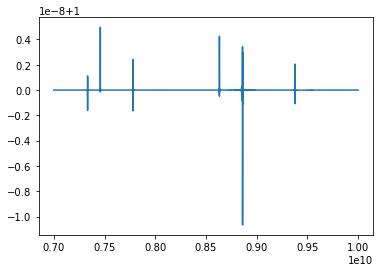

In [25]:
from matplotlib import pyplot as plt
# plt.plot(f_, np.abs(s11))
plt.plot(f_, np.abs(s11))

In [20]:
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
f[:10]/(2*np.pi)/1e9, delta[:10]/1e6,f[:10]/delta[:10]/2 

(array([4.9014055 , 4.9024689 , 4.93759082, 4.93772351, 7.33342141,
        7.45865208, 7.78215027, 8.63263461, 8.860829  , 9.37778056]),
 array([5.59366370e-05, 2.67812533e-04, 7.29355262e-04, 1.86778590e-04,
        2.21155597e-02, 6.04643293e-01, 2.46727017e+00, 6.51384681e-01,
        3.04869697e+00, 3.15095763e+00]),
 array([2.75279679e+08, 5.75087362e+07, 2.12679607e+07, 8.30518951e+07,
        1.04173818e+06, 3.87535045e+04, 9.90906729e+03, 4.16347241e+04,
        9.13082395e+03, 9.34990879e+03]))